In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import tweepy
import numpy as np
import json
from datetime import datetime
from mpl_toolkits.basemap import Basemap
import os

In [2]:
health_data_path = os.path.join('Data Sets', 'health_data', 'SUMMARYMEASURESOFHEALTH.csv')

fields = ['CHSI_County_Name','CHSI_State_Name','ALE','All_Death','Health_Status']

health_df = pd.read_csv(health_data_path, skipinitialspace=True, usecols=fields)

health_df = health_df.rename(columns={'CHSI_County_Name':'County',
                                    'CHSI_State_Name':'State'})

health_df.columns

Index(['County', 'State', 'ALE', 'All_Death', 'Health_Status'], dtype='object')

In [3]:
health_df.head(1)

,County,State,ALE,All_Death,Health_Status
0,Autauga,Alabama,74.9,1041.5,21.8


In [4]:
census_data_path = os.path.join('Data Sets', 'acs2015_county_data.csv')

fields = ['State', 'County', 'TotalPop', 'Income', 'IncomePerCap', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'Unemployment']

census_df = pd.read_csv(census_data_path, skipinitialspace=True, usecols=fields)

census_df.columns

Index(['State', 'County', 'TotalPop', 'Income', 'IncomePerCap', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'Unemployment'],
      dtype='object')

In [5]:
census_df.head(1)

,State,County,TotalPop,Income,IncomePerCap,Poverty,ChildPoverty,Professional,Service,Office,...,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,Unemployment
0,Alabama,Autauga,55221,51281.0,24974,12.9,18.6,33.2,17.0,24.2,...,17.1,87.5,8.8,0.1,0.5,1.3,1.8,26.5,23986,7.6


In [6]:
merged_df = pd.merge(health_df,census_df,on=['County','State'],how='outer')
merged_df.head(5)

,County,State,ALE,All_Death,Health_Status,TotalPop,Income,IncomePerCap,Poverty,ChildPoverty,...,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,Unemployment
0,Autauga,Alabama,74.9,1041.5,21.8,55221.0,51281.0,24974.0,12.9,18.6,...,17.1,87.5,8.8,0.1,0.5,1.3,1.8,26.5,23986.0,7.6
1,Baldwin,Alabama,76.6,856.9,15.4,195121.0,50254.0,27317.0,13.4,19.2,...,11.2,84.7,8.8,0.1,1.0,1.4,3.9,26.4,85953.0,7.5
2,Barbour,Alabama,74.5,1019.4,21.4,26932.0,32964.0,16824.0,26.7,45.3,...,23.1,83.8,10.9,0.4,1.8,1.5,1.6,24.1,8597.0,17.6
3,Bibb,Alabama,73.2,1050.5,19.4,22604.0,38678.0,18431.0,16.8,27.9,...,23.7,83.2,13.5,0.5,0.6,1.5,0.7,28.8,8294.0,8.3
4,Blount,Alabama,76.1,954.2,25.8,57710.0,45813.0,20532.0,16.7,27.2,...,19.9,84.9,11.2,0.4,0.9,0.4,2.3,34.9,22189.0,7.7


In [7]:
california_df = merged_df.loc[merged_df['State'] == 'California']
california_df = california_df.reset_index(drop=True)
california_df.head(1)

,County,State,ALE,All_Death,Health_Status,TotalPop,Income,IncomePerCap,Poverty,ChildPoverty,...,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,Unemployment
0,Alameda,California,78.1,751.0,11.9,1584983.0,75619.0,37285.0,12.5,15.2,...,9.3,63.6,9.9,13.6,3.7,3.5,5.6,30.7,778132.0,8.3


<function matplotlib.pyplot.show>

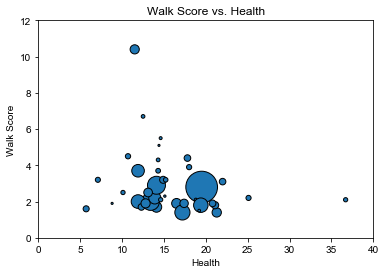

In [8]:
plt.scatter(x=california_df['Health_Status'], 
            y=california_df['Walk'],
            edgecolors = 'black',
            s=california_df['TotalPop']/10000,
            marker = 'o',
            linewidth = 1.0) 
#plt.legend(california_df['County'],title=('County'),bbox_to_anchor=(1.2,1), fancybox=True,fontsize=8)

plt.title('Walk Score vs. Health')
plt.xlabel('Health',fontsize=10)
plt.ylabel('Walk Score',fontsize=10)
plt.xlim(0,40)
plt.ylim(0,12)        
sea.set()

#plt.savefig("TemperatureInWorldCities3.png")

plt.show


In [9]:
geo_path = os.path.join('Data Sets', 'uscitiesv1.3.csv')
geo_data = pd.read_csv(geo_path)

# Extract the data we're interested in
lat = geo_data['lat'].values
lon = geo_data['lng'].values
population = geo_data['population'].values
#area = geo_data['area_total_km2'].values

/Users/adammercier/anaconda3/envs/myenvironment/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/adammercier/anaconda3/envs/myenvironment/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/adammercier/anaconda3/envs/myenvironment/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10
/Users/adammercier/anaconda3/envs/myenvironment/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/adammercier/anaconda3/envs/myenvironment/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecatio

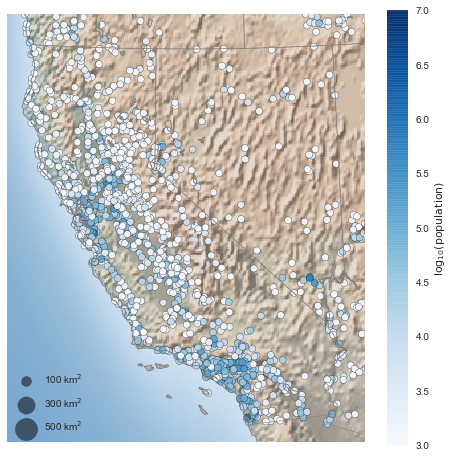

In [15]:
# 1. Draw the map background
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=37.5, lon_0=-119,
            width=1E6, height=1.2E6)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, 
          lat, 
          latlon=True,
          c=np.log10(population),
          cmap='Blues', 
          alpha=0.9,
         edgecolors = 'black')
# s=area,
# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm population})$')
plt.clim(3, 7)

# make legend with dummy points
for a in [100, 300, 500]:
    plt.scatter([], 
                [], 
                c='k', 
                alpha=0.5, 
                s=a,
                label=str(a) + ' km$^2$')
    
plt.legend(scatterpoints=1, 
           frameon=False,
           labelspacing=1, 
           loc='lower left')

In [ ]:
cal_avg_ale = california_df['ALE'].mean()
cal_avg_death = california_df['All_Death'].mean()
cal_avg_health = california_df['Health_Status'].mean()